In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip deeptrack.zip

Archive:  deeptrack.zip
  inflating: deeptrack/__init__.py   
   creating: deeptrack/__pycache__/
  inflating: deeptrack/__pycache__/__init__.cpython-39.pyc  
  inflating: deeptrack/__pycache__/aberrations.cpython-39.pyc  
  inflating: deeptrack/__pycache__/augmentations.cpython-39.pyc  
  inflating: deeptrack/__pycache__/elementwise.cpython-39.pyc  
  inflating: deeptrack/__pycache__/features.cpython-39.pyc  
  inflating: deeptrack/__pycache__/generators.cpython-39.pyc  
  inflating: deeptrack/__pycache__/image.cpython-39.pyc  
  inflating: deeptrack/__pycache__/layers.cpython-39.pyc  
  inflating: deeptrack/__pycache__/losses.cpython-39.pyc  
  inflating: deeptrack/__pycache__/math.cpython-39.pyc  
  inflating: deeptrack/__pycache__/noises.cpython-39.pyc  
  inflating: deeptrack/__pycache__/optics.cpython-39.pyc  
  inflating: deeptrack/__pycache__/properties.cpython-39.pyc  
  inflating: deeptrack/__pycache__/scatterers.cpython-39.pyc  
  inflating: deeptrack/__pycache__/sequences.c

In [ ]:
pip install pint

In [ ]:
import deeptrack as dt
from deeptrack.models.yolo import utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from simulation import *

/content/deeptrack/backend/_config.py:12: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  "cupy not installed. GPU-accelerated simulations will not be possible"
/content/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [ ]:
starting_value = dt.Value(lambda: np.ones((IMAGE_SIZE, IMAGE_SIZE)))

sim= starting_value >> MultiParticle(
    n_particles = lambda: int(np.random.rand()*10) + 35,
)

particle =  sim[0]
pos =  sim[1]
rad =  sim[2]






In [ ]:
print(np.shape(particle.resolve()))

Image((100, 100, 1))


In [ ]:
gradient = dt.IlluminationGradient(
    gradient=[.5e-3, 0e-3],#lambda: 1e-3 + np.random.randn(2) * 1e-3,
)

class Normalize(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image / np.max(image)
        return image

class Rescale(dt.Feature):
    def __init__(
        self, **kwargs
    ):
        super().__init__( **kwargs)

    def get(self, image, **kwargs):
        image = image * np.ones(1)*256.0
        
        return image

rescaling = Rescale()
normalization = Normalize()

gauss = dt.Gaussian(mu = 0, sigma = .01)

import scipy
#Smoothing
#kernel = np.ones((5, 5, 1)) / np.random.normal(loc = 28, scale = 5, size =1)
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, np.ones((3, 3, 1)) / np.random.normal(loc = 10, scale = 1, size =1))) 

particle = particle  >> smoothing >> rescaling# >> normalization# >> gauss 


In [ ]:
particle.resolve()

Image(array([[[210.80907384],
        [210.05462199],
        [201.58496626],
        ...,
        [205.13385524],
        [202.21111665],
        [196.65750024]],

       [[207.74691895],
        [203.98529708],
        [195.65039437],
        ...,
        [199.28320066],
        [199.38651832],
        [196.76711198]],

       [[206.26219657],
        [202.77754606],
        [198.33771913],
        ...,
        [196.43493232],
        [197.62129347],
        [198.85402672]],

       ...,

       [[196.25815445],
        [202.77229803],
        [207.36393743],
        ...,
        [196.41814229],
        [197.65734443],
        [191.36567425]],

       [[197.51546657],
        [201.08583201],
        [202.7294977 ],
        ...,
        [197.38330517],
        [198.24209683],
        [197.21408684]],

       [[196.10138228],
        [197.24691019],
        [197.61473184],
        ...,
        [198.95557237],
        [200.74196913],
        [203.61147362]]]))

In [ ]:

def get_label(rad, pos):
    rad = np.array(rad)
    rad = rad.astype(int)
    pos = np.array(pos)
    pos = pos.astype(int)    

    n = np.shape(rad)[0]  
    label = np.zeros((n, 5))
    top_left = np.zeros((n,2))
    bottom_right = np.zeros((n,2))
    top_left[:,0] = pos[:, 0]- 1.5*rad[:,0]
    top_left[:,1] = pos[:, 1]- 1.5*rad[:,0]
    bottom_right[:,0] = pos[:, 0]+ 1.5*rad[:,0]
    bottom_right[:,1] = pos[:, 1]+ 1.5*rad[:,0]

    for i in range ( n ):
        label[i, : ] = [top_left[i,0], top_left[i,1], bottom_right[i, 0], bottom_right[i,1], 0]
    
    #print(label)
    return label.astype(int)

In [ ]:

label_func = particle >> dt.Lambda(lambda rad, pos: lambda x: get_label(rad, pos), rad=rad, pos=pos)
bboxes = label_func.resolve()
print(bboxes)

Image(array([[66, 50, 72, 56,  0],
       [29, 20, 35, 26,  0],
       [50,  1, 59, 10,  0],
       [64, 18, 73, 27,  0],
       [11, 81, 17, 87,  0],
       [14, 65, 20, 71,  0],
       [26,  3, 35, 12,  0],
       [30, 62, 39, 71,  0],
       [85, 12, 94, 21,  0],
       [12,  3, 21, 12,  0],
       [27, 59, 33, 65,  0],
       [75, 56, 84, 65,  0],
       [64, 83, 73, 92,  0],
       [ 8, 20, 17, 29,  0],
       [49, 43, 58, 52,  0],
       [69, 64, 78, 73,  0],
       [79, 13, 85, 19,  0],
       [39,  9, 45, 15,  0],
       [69, 80, 75, 86,  0],
       [57, 62, 63, 68,  0],
       [86, 33, 95, 42,  0],
       [ 8, 49, 17, 58,  0],
       [34, 17, 40, 23,  0],
       [42, 71, 48, 77,  0],
       [62,  5, 68, 11,  0],
       [76, 69, 88, 81,  0],
       [82, 84, 88, 90,  0],
       [ 0, 28,  9, 37,  0],
       [42, 56, 51, 65,  0],
       [45, 28, 54, 37,  0],
       [74, 88, 80, 94,  0],
       [57, 76, 66, 85,  0],
       [23, 48, 29, 54,  0],
       [ 5, 85, 14, 94,  0],
       [

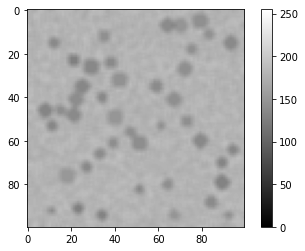

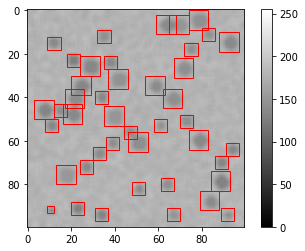

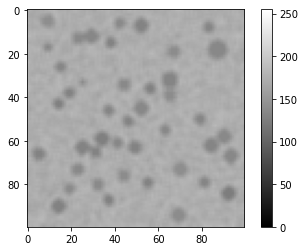

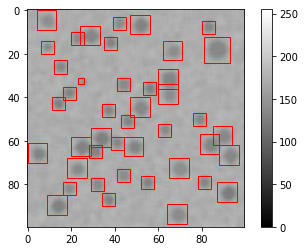

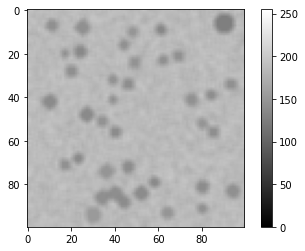

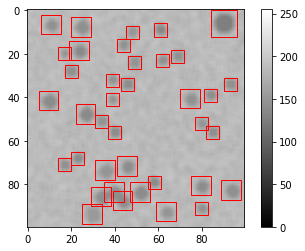

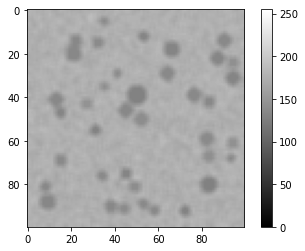

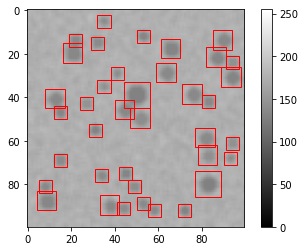

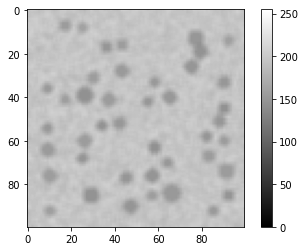

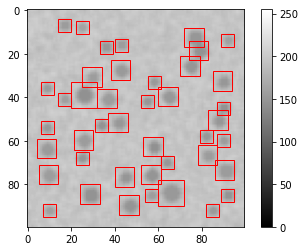

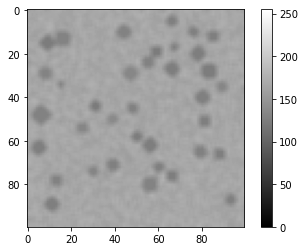

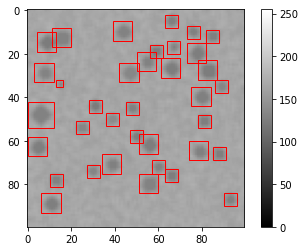

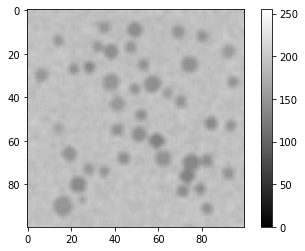

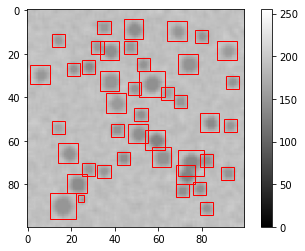

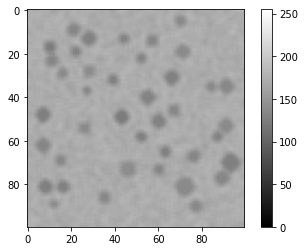

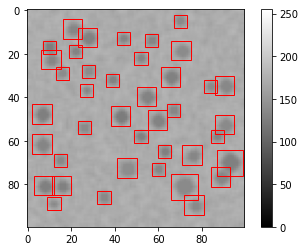

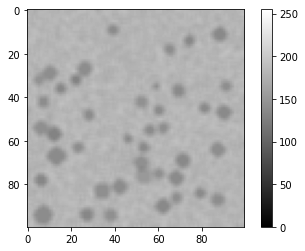

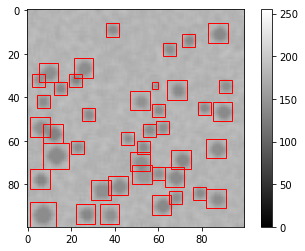

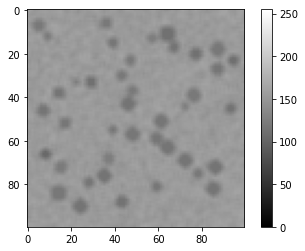

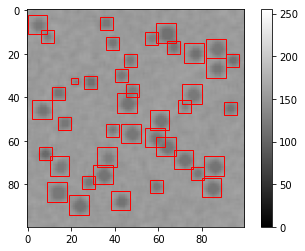

In [ ]:
data = particle & label_func

NUMBER_OF_IMAGES = 10

for _ in range(NUMBER_OF_IMAGES):

    image_of_particle, bbox = data.update().resolve()
    bbox = np.array(bbox)

    n = np.shape(bbox)[0]
    plt.imshow(np.reshape(image_of_particle,(100,100)), cmap="gray", vmin=0, vmax = 255)
    plt.colorbar()
    plt.show()
    plt.imshow(np.reshape(image_of_particle,(100,100)), cmap="gray", vmin=0, vmax = 255)
    plt.colorbar()
    ax = plt.gca()
    for i in range(int(n)):
        rect = plt.Rectangle(
            (
                bbox[i, 0],
                bbox[
                    i, 1
                ],
            ),
            bbox[i, 2] - bbox[i, 0],
            bbox[i, 3] - bbox[i, 1],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    # plt.scatter(position_of_particles[:,0], position_of_particles[:,1], marker='+', edgecolors="r", linewidth=2)
    plt.show()
    """histogram, bin_edges = np.histogram(np.reshape(image_of_particle,(100,100)), bins=256, range=(0, 255))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram of simulation")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])  # <- named arguments do not work here

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()"""

In [ ]:
from tensorflow import keras

from deeptrack.models.yolo.yolo import YOLOv3

model = YOLOv3(
    (100, 100, 1),
    1,
    ANCHORS = [6, 8, 10, 12, 14, 16, 18, 20]
)

opt = keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0001

model.compile(optimizer=opt, loss_weights= [1, 1, 2])#

In [ ]:
from deeptrack.models.yolo.dataset import YoloDataGenerator

generator = YoloDataGenerator(
    feature=data,
    input_size=np.array([100]),
    num_class=1,
    label_function=lambda d: np.array(d[1]),
    batch_size=4,
    min_data_size=250,
    max_data_size=300,
)

generator.anchors = model.anchors

In [ ]:
with generator:
    model.fit(generator, epochs=50)

Generating 259 / 250 samples before starting training


/content/deeptrack/generators.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data), np.array(labels)


Epoch 1/50
64/64 [==============================] - 136s 2s/step - loss: 145.9140 - giou_loss: 93.6265 - conf_loss: 41.2365 - prob_loss: 11.0510
Epoch 2/50
64/64 [==============================] - 135s 2s/step - loss: 112.9443 - giou_loss: 81.0137 - conf_loss: 30.9306 - prob_loss: 1.0000
Epoch 3/50
64/64 [==============================] - 132s 2s/step - loss: 109.3210 - giou_loss: 78.5730 - conf_loss: 30.0444 - prob_loss: 0.7035
Epoch 4/50
64/64 [==============================] - 124s 2s/step - loss: 103.5217 - giou_loss: 74.3913 - conf_loss: 28.6849 - prob_loss: 0.4454
Epoch 5/50
64/64 [==============================] - 121s 2s/step - loss: 90.6187 - giou_loss: 67.9737 - conf_loss: 22.1985 - prob_loss: 0.4465
Epoch 6/50
64/64 [==============================] - 132s 2s/step - loss: 91.5880 - giou_loss: 70.8511 - conf_loss: 20.3647 - prob_loss: 0.3722
Epoch 7/50
64/64 [==============================] - 124s 2s/step - loss: 88.3606 - giou_loss: 69.7808 - conf_loss: 18.2427 - prob_loss: 0

In [ ]:
model.save("/content/drive/MyDrive/multi_particle4")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/multi_particle4/assets


In [ ]:
model.load_weights("/content/drive/MyDrive/multi_particle4")

Generating 263 / 250 samples before starting training


/content/deeptrack/generators.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data), np.array(labels)


(1, 100, 100, 1)


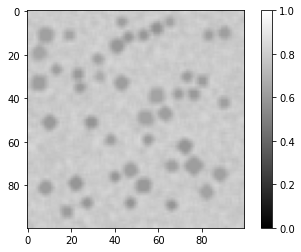

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


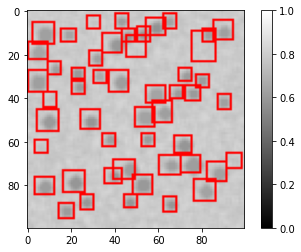

(1, 100, 100, 1)


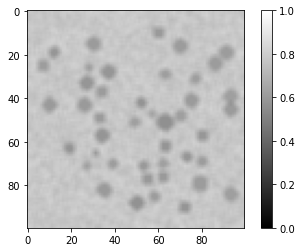

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


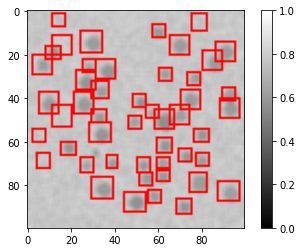

(1, 100, 100, 1)


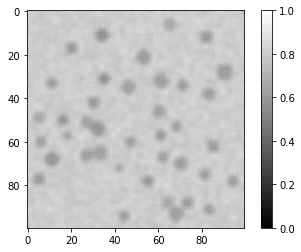

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


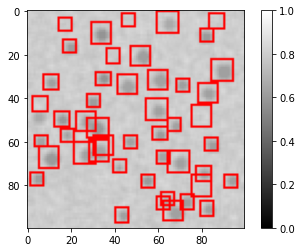

(1, 100, 100, 1)


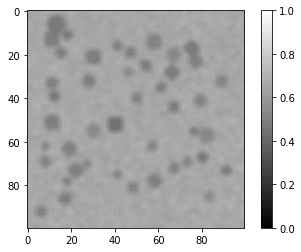

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


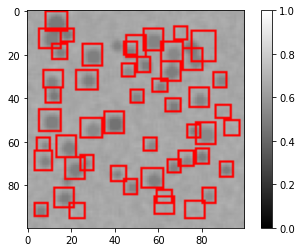

In [ ]:
model.score_threshold = 0.4
with generator:
    A, B = generator[1]

for i in range(4):
            
    X = A[i:i+1]

    print(np.shape(X))
    y = model(X)

    boxes = y[:, :, 0:4]
    pred_conf = y[:, :, 4:]

    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=0.5,
        score_threshold=0.4,
    )

    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    x = np.repeat(X[0], 3, axis=-1)
    plt.imshow(x, cmap="gray", vmin =0, vmax = 1)
    plt.colorbar()
    plt.show()
    x = dt.models.yolo.utils.draw_bbox(x, pred_bbox, classes=["1"], show_label = False )
    #print(x)
    plt.imshow(x, cmap="gray", vmin =0, vmax = 1)
    plt.colorbar()
    plt.show()


In [ ]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/5fps.tif')
im.show()
im = np.array(im)/255


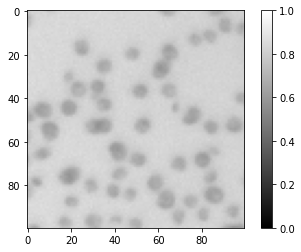

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)


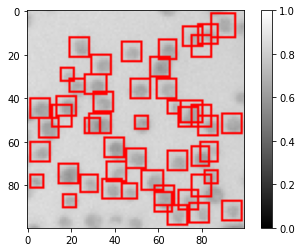

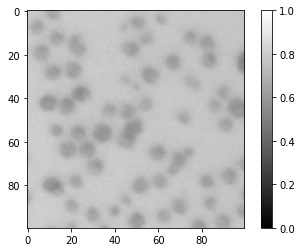

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)


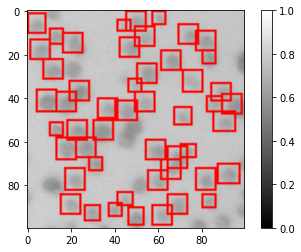

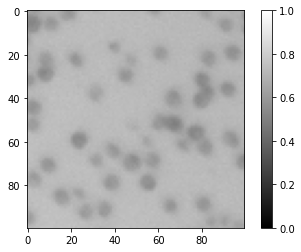

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)


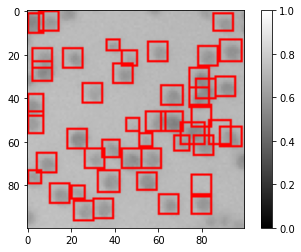

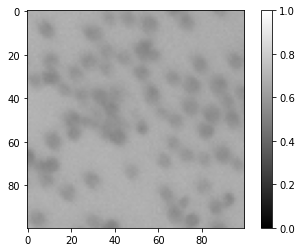

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)


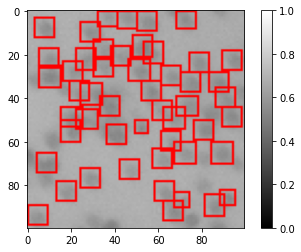

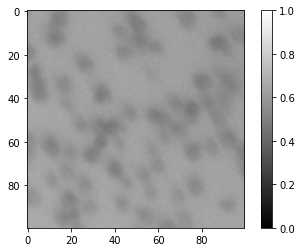

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 3)


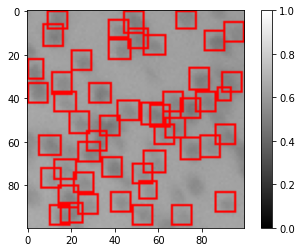

In [ ]:
for i in range(5):
  img = im[:,2000+(i*200):2100+(i*200)]
  img = np.expand_dims(img,axis = 0)
  img = np.expand_dims(img,axis = 3)

  img = tf.convert_to_tensor(img, dtype=tf.float32)

  y = model(img)

  boxes = y[:, :, 0:4]
  pred_conf = y[:, :, 4:]

  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
      boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
      scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
      max_output_size_per_class=50,
      max_total_size=50,
      iou_threshold=0.5,
      score_threshold=0.4,
  )

  pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
  x = np.repeat(img[0], 3, axis=-1)
  plt.imshow(x, cmap="gray", vmin =0, vmax = 1)
  plt.colorbar()
  plt.show()
  print(np.shape(x))
  x = dt.models.yolo.utils.draw_bbox(x, pred_bbox, classes=["1"], show_label=False)
  #print(np.shape(x))
  plt.imshow(x, cmap="gray", vmin =0, vmax = 1)
  plt.colorbar()
  plt.show()

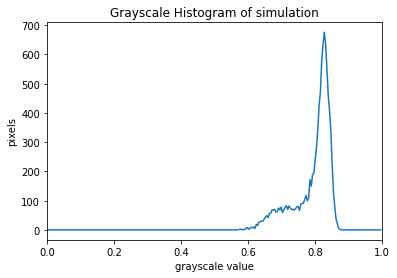

In [ ]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 1))

# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram of simulation")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()